# Bibliotécas

In [10]:
import re
import pandas  as pd
import numpy   as np
import seaborn as sns
import folium
import pickle
from math                    import radians, sin, cos, sqrt, atan2
from sklearn.metrics         import mean_squared_error, mean_absolute_error
from sklearn.multioutput     import MultiOutputRegressor
from sklearn.model_selection import TimeSeriesSplit, KFold, GridSearchCV
from xgboost                 import XGBRegressor
from boruta                  import BorutaPy
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from matplotlib.gridspec     import GridSpec
from sklearn.linear_model    import LinearRegression
from sklearn.ensemble        import RandomForestRegressor
from datetime                import datetime, timezone
from matplotlib              import pyplot          as plt
from sklearn                 import model_selection as ms
import warnings
warnings.filterwarnings('ignore')

# Funções

In [11]:
def haversine(lat1, lon1, lat2, lon2):
    # Raio médio da Terra em metros
    raio_terra = 6371000.0

    # Converte graus para radianos
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Diferenças de coordenadas
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Fórmula de Haversine
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distância em metros
    distancia = raio_terra * c

    return distancia

def metricas_error(nome_modelo, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    return pd.DataFrame({'nome_algoritmo': nome_modelo,
                         'mae': mae,
                         'mape': mape,
                         'rmse': rmse}, index = [0])

def mean_absolute_percentage_error(y_validacao_aux, y_pred):
    return np.mean(np.abs((y_validacao_aux - y_pred) / y_validacao_aux))
    
def cross_validation(nome_modelo, modelo, x_treino, verbose = True):
    # Variável longitude 
    time_split = TimeSeriesSplit(n_splits = 5)       

    mae_list = []
    mape_list = []
    rmse_list = []
    
    #for treino_index, validacao_index in time_split.split(x_treino):
    for fold, (treino_index, validacao_index) in enumerate(time_split.split(x_treino), 1):
        # Criando conjuntos de treino e validação usando os índices
        x_treino_aux, x_validacao_aux = x_treino.iloc[treino_index], x_treino.iloc[validacao_index]
        y_treino_aux, y_validacao_aux = y_treino.iloc[treino_index], y_treino.iloc[validacao_index]

        # Envolvendo o modelo usando MultiOutputRegressor
        multioutput_regressor = MultiOutputRegressor(modelo)
        
        # Treinando o modelo de regressão linear
        multioutput_regressor.fit(x_treino_aux, y_treino_aux)
    
        # Fazendo previsões no conjunto de validação
        y_pred = multioutput_regressor.predict(x_validacao_aux)
        
        # Avaliando o desempenho
        mse = mean_squared_error(y_validacao_aux, y_pred)        
        rmse = np.sqrt(mse)

        mae = mean_absolute_error(y_validacao_aux, y_pred)
        mape = mean_absolute_percentage_error(y_validacao_aux, y_pred)
        
        # Armazenando os resultados de desempenho
        rmse_list.append(rmse)
        mae_list.append(mae)
        mape_list.append(mape)

        if verbose:
            print(f"Fold {fold}:")
            print("Conjunto de Treino - Início:", treino_index[0], "Fim:", treino_index[-1])
            print("Conjunto de Validação - Início:", validacao_index[0], "Fim:", validacao_index[-1])
            print("-----")        

    return pd.DataFrame({'algoritmo': [nome_modelo],
                         'rmse': round(np.mean(rmse_list), 4).astype(str) + '+/-' + round(np.std(rmse_list), 4).astype(str),
                         'mae': round(np.mean(mae_list), 4).astype(str) + '+/-' + round(np.std(mae_list), 4).astype(str),
                         'mape': round(np.mean(mape_list), 4).astype(str) + '+/-' + round(np.std(mape_list), 4).astype(str)})  

# 1. (Limpeza dos dados) Passo 1: Descrição dos dados

### 1.1 Descrição do desafio

Descrição

A indústria de táxis está evoluindo rapidamente. Novos concorrentes e tecnologias estão mudando a forma como os serviços de táxi tradicionais fazem negócios. Embora esta evolução tenha criado novas eficiências, também criou novos problemas.

Uma mudança importante é a adoção generalizada de sistemas de despacho eletrônico que substituíram os sistemas de despacho de rádio VHF de tempos passados. Esses terminais móveis de dados são instalados em cada veículo e normalmente fornecem informações sobre localização GPS e estado do taxímetro. Os sistemas de despacho eletrônico facilitam a visualização de onde um táxi esteve, mas não necessariamente para onde está indo. Na maioria dos casos, os taxistas que operam com sistema de despacho eletrônico não indicam o destino final da viagem atual.

Outra mudança recente é a mudança de mensagens de rádio baseadas em transmissão (um para muitos) para despacho de serviço para mensagens baseadas em unicast (um para um). Com mensagens unicast, o despachante precisa identificar corretamente qual táxi deve despachar para o local de coleta. Como os táxis que utilizam sistemas de despacho eletrônico geralmente não entram no local de entrega, é extremamente difícil para os despachantes saber qual táxi contatar.

Para melhorar a eficiência dos sistemas electrónicos de despacho de táxis é importante ser capaz de prever o destino final de um táxi enquanto este está em serviço. Particularmente durante períodos de alta demanda, muitas vezes há um táxi cuja corrida atual terminará próximo ou exatamente no local de retirada solicitado por um novo passageiro. Se um despachante soubesse aproximadamente onde seus motoristas de táxi terminariam suas viagens atuais, ele seria capaz de identificar qual táxi atribuir a cada solicitação de coleta.

A trajetória espacial de um táxi ocupado poderia fornecer algumas dicas sobre para onde ele está indo. Da mesma forma, dado o id do táxi, poderá ser possível prever o seu destino final com base na regularidade dos serviços pré-contratados. Num número significativo de viagens de táxi (aproximadamente 25%), o táxi foi chamado através do call center de táxi e a identificação telefónica do passageiro pode ser usada para restringir a previsão do destino com base nos dados históricos da viagem ligados à sua identificação telefónica.

Neste desafio, pedimos-lhe que construa uma estrutura preditiva que seja capaz de inferir o destino final das corridas de táxi no Porto, Portugal, com base nas suas trajetórias parciais (iniciais). A saída desse quadro deve ser o destino final da viagem (coordenadas WGS84).

Este é o primeiro de dois desafios da ciência de dados que compartilham o mesmo conjunto de dados. A competição Taxi Service Trip Time prevê o tempo total de viagens de táxi.

### 1.2 Carregar os dados

In [ ]:
# Como os dados são muito grandes, serão selecionadas as colunas necessárias antes de importar os dados
colunas_treino_teste = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'TAXI_ID', 'ORIGIN_STAND', 'TIMESTAMP', 'POLYLINE']

df_treino_raw = pd.read_csv('dataset/train.csv', usecols = colunas_treino_teste)
df_teste_raw = pd.read_csv('dataset/test.csv', usecols = colunas_treino_teste)

In [12]:
df_localizacao_raw = pd.read_csv('dataset/metaData_taxistandsID_name_GPSlocation.csv')
df1_localizacao = df_localizacao_raw.copy()

In [13]:
df_treino_raw.info(memory_usage = 'deep')

NameError: name 'df_treino_raw' is not defined

In [4]:
df1 = df_treino_raw.copy()
df1_teste = df_teste_raw.copy()

NameError: name 'df_treino_raw' is not defined

### 1.3 Dimensão dos dados

In [6]:
df1.shape, df1_teste.shape, df1_localizacao.shape

((1710670, 7), (320, 7), (63, 4))

In [7]:
df1.head(2)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."


In [8]:
df1_teste.head(2)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,POLYLINE
0,T1,B,NaN,15.0,20000542,1408039037,"[[-8.585676,41.148522],[-8.585712,41.148639],[..."
1,T2,B,NaN,57.0,20000108,1408038611,"[[-8.610876,41.14557],[-8.610858,41.145579],[-..."


In [9]:
df1_localizacao.head(2)

,ID,Descricao,Latitude,Longitude
0,1,Agra,41.1771457135,-8.609670
1,2,Alameda,41.15618964,-8.591064


### 1.4 Editar as colunas

In [10]:
df1.columns = df1.columns.str.lower()
df1_teste.columns = df1_teste.columns.str.lower()

### 1.5 Tipo de dados

In [11]:
df1.dtypes

trip_id           int64
call_type        object
origin_call     float64
origin_stand    float64
taxi_id           int64
timestamp         int64
polyline         object
dtype: object

In [12]:
df1_teste.dtypes

trip_id          object
call_type        object
origin_call     float64
origin_stand    float64
taxi_id           int64
timestamp         int64
polyline         object
dtype: object

In [13]:
#Convertendo a coluna 'trip_id' para string
df1['trip_id'] = df1['trip_id'].astype(str)

#Convertendo a coluna 'taxi_id' para string
df1['taxi_id'] = df1['taxi_id'].astype(str)

#Convertendo a coluna 'taxi_id' para string
df1_teste['taxi_id'] = df1_teste['taxi_id'].astype(str)

### 1.6 Verificar NA's

In [14]:
df1.isna().sum() / df1.shape[0]

trip_id         0.000000
call_type       0.000000
origin_call     0.786768
origin_stand    0.528501
taxi_id         0.000000
timestamp       0.000000
polyline        0.000000
dtype: float64

In [15]:
df1_teste.isna().sum() / df1_teste.shape[0]

trip_id         0.000000
call_type       0.000000
origin_call     0.775000
origin_stand    0.615625
taxi_id         0.000000
timestamp       0.000000
polyline        0.000000
dtype: float64

#### 1.6.1 Tratar NA's

In [16]:
#Preenchendo os NA's com 0
df1['origin_call'].fillna(0, inplace = True)
df1['origin_stand'].fillna(0, inplace = True)

#Preenchendo os NA's com 0
df1_teste['origin_call'].fillna(0, inplace = True)
df1_teste['origin_stand'].fillna(0, inplace = True)

#### 1.6.2 Verificar NA's novamente

In [17]:
df1.isna().sum() / df1.shape[0]

trip_id         0.0
call_type       0.0
origin_call     0.0
origin_stand    0.0
taxi_id         0.0
timestamp       0.0
polyline        0.0
dtype: float64

In [18]:
df1_teste.isna().sum() / df1_teste.shape[0]

trip_id         0.0
call_type       0.0
origin_call     0.0
origin_stand    0.0
taxi_id         0.0
timestamp       0.0
polyline        0.0
dtype: float64

In [19]:
#Convertendo a coluna 'origin_call' para inteiro
df1['origin_call'] = df1['origin_call'].astype(str)

#Convertendo a coluna 'origin_stand' para inteiro
df1['origin_stand'] = df1['origin_stand'].astype(str)

#Convertendo a coluna 'origin_call' para inteiro
df1_teste['origin_call'] = df1_teste['origin_call'].astype(str)

#Convertendo a coluna 'origin_stand' para inteiro
df1_teste['origin_stand'] = df1_teste['origin_stand'].astype(str)

### 1.7 Descrição estatística do negócio

#### 1.7.1 Descrição das colunas

Conjunto de dados de treinamento

Fornecemos um conjunto de dados preciso que descreve um ano completo (de 01/07/2013 a 30/06/2014) das trajetórias de todos os 442 táxis que circulam na cidade do Porto, em Portugal (ou seja, um arquivo CSV denominado "train. CSV"). Estes táxis funcionam através de uma central de despacho de táxis, utilizando terminais móveis de dados instalados nos veículos. Classificamos cada viagem em três categorias: A) com base em central de táxi, B) com base em ponto ou C) com base em central não-táxi. Para o primeiro, disponibilizamos um id anônimo, quando tal informação estiver disponível na ligação telefônica. As duas últimas categorias referem-se a serviços que eram demandados diretamente aos taxistas em B) ponto de táxi ou em C) rua aleatória.

Cada amostra de dados corresponde a uma viagem concluída. Contém um total de
9 (nove) funcionalidades, descritas a seguir:

**1. TRIP_ID** -> (String) Contém um identificador único para cada viagem;

**2. CALL_TYPE** -> (char) Identifica a forma utilizada para demandar este serviço. Pode conter um dos três valores possíveis:
'A' se esta viagem foi despachada da central;
'B' se esta viagem foi solicitada diretamente a um taxista em ponto específico;
'C' caso contrário (ou seja, uma viagem exigida em uma rua aleatória).

**3. ORIGIN_CALL** -> (inteiro) Contém um identificador único para cada número de telefone que foi utilizado para demandar, pelo menos, um serviço. Identifica o cliente da viagem se CALL_TYPE='A'. Caso contrário, assume um valor NULL;

**4. ORIGIN_STAND** -> (inteiro): Contém um identificador único do ponto de táxi. Identifica o ponto inicial da viagem se CALL_TYPE='B'. Caso contrário, assume um valor NULL;

**5. TAXI_ID** -> (inteiro): Contém um identificador único do taxista que realizou cada viagem;

**6. TIMESTAMP** -> (inteiro) carimbo de data/hora Unix (em segundos). Identifica o início da viagem; 

**7. DAYTYPE** -> (char) Identifica o tipo de dia de início da viagem. Ele assume um dos três valores possíveis:
'B' se esta viagem começou num feriado ou em qualquer outro dia especial (ou seja, feriados prolongados, feriados flutuantes, etc.);
'C' se a viagem começou um dia antes de um dia tipo B;
'A' caso contrário (ou seja, um dia normal, dia útil ou fim de semana).

**8. MISSING_DATA** -> (Booleano) É FALSE quando o fluxo de dados GPS está completo e TRUE sempre que um (ou mais) locais estão faltando.

**9. POLYLINE** -> (String): Contém uma lista de coordenadas GPS (ou seja, formato WGS84) mapeadas como uma string. O início e o fim da string são identificados entre colchetes (ou seja, [ e ], respectivamente). Cada par de coordenadas também é identificado pelos mesmos colchetes que [LONGITUDE, LATITUDE]. Esta lista contém um par de coordenadas para cada 15 segundos de viagem. O último item da lista corresponde ao destino da viagem enquanto o primeiro representa o seu início;

II. Teste
Cinco conjuntos de testes estarão disponíveis para avaliar sua estrutura preditiva (em um único arquivo CSV denominado "test.csv"). Cada um destes conjuntos de dados refere-se a viagens ocorridas entre 01/07/2014 e 31/12/2014. Cada um desses conjuntos de dados fornecerá um instantâneo do status atual da rede em um determinado carimbo de data/hora. Fornecerá trajetórias parciais para cada uma das viagens em andamento naquele momento específico.

Os cinco instantâneos incluídos no conjunto de testes referem-se aos seguintes carimbos de data/hora:

14/08/2014 18:00:00
30/09/2014 08:30:00
06/10/2014 17:45:00
01/11/2014 04:00:00
21/12/2014 14:30:00

#### 1.7.2 Separar as colunas em variáveis numéricas e variáveis categóricas

#### 1.7.4 Atributos categóricos

In [20]:
#Encontrando a qtdes de tipos de categorias existem em cada coluna categórica
df1.select_dtypes(exclude = ['int64']).apply(lambda x: x.unique().shape[0])

trip_id         1710589
call_type             3
origin_call       57106
origin_stand         64
taxi_id             448
polyline        1703650
dtype: int64

# 2. (Limpeza dos dados) Passo 2: Engenharia de atributos

In [21]:
df2 = df1.copy()
df2_teste = df1_teste.copy()

### 2.1 Derivando as variáveis a partir das variáveis originais

In [22]:
df2.head(3)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,polyline
0,1372636858620000589,C,0.0,0.0,20000589,1372636858,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,0.0,7.0,20000596,1372637303,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,0.0,0.0,20000320,1372636951,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."


In [23]:
df2_teste.head(3)

,trip_id,call_type,origin_call,origin_stand,taxi_id,timestamp,polyline
0,T1,B,0.0,15.0,20000542,1408039037,"[[-8.585676,41.148522],[-8.585712,41.148639],[..."
1,T2,B,0.0,57.0,20000108,1408038611,"[[-8.610876,41.14557],[-8.610858,41.145579],[-..."
2,T3,B,0.0,15.0,20000370,1408038568,"[[-8.585739,41.148558],[-8.58573,41.148828],[-..."


In [24]:
# Extraindo a data da coluna 'timestamp'
#Dados de treino
df2['timestamp'] = [float(time) for time in df2['timestamp']]
df2['data_time'] = [datetime.fromtimestamp(time, timezone.utc) for time in df2['timestamp']]
df2['ano'] = pd.to_datetime(df2['data_time']).dt.year
df2['mes'] = pd.to_datetime(df2['data_time']).dt.month
df2['semana'] = pd.to_datetime(df2['data_time']).dt.weekday
df2['dia'] = pd.to_datetime(df2['data_time']).dt.day
df2['hora'] = pd.to_datetime(df2['data_time']).dt.hour
df2['minuto'] = pd.to_datetime(df2['data_time']).dt.minute
df2['data_hora'] = df2['data_time'].astype(str).str.split('+').str[0].str.strip()

#Dados de teste
df2_teste['timestamp'] = [float(time) for time in df2_teste['timestamp']]
df2_teste['data_time'] = [datetime.fromtimestamp(time, timezone.utc) for time in df2_teste['timestamp']]
df2_teste['ano'] = pd.to_datetime(df2_teste['data_time']).dt.year
df2_teste['mes'] = pd.to_datetime(df2_teste['data_time']).dt.month
df2_teste['semana'] = pd.to_datetime(df2_teste['data_time']).dt.weekday
df2_teste['dia'] = pd.to_datetime(df2_teste['data_time']).dt.day
df2_teste['hora'] = pd.to_datetime(df2_teste['data_time']).dt.hour
df2_teste['minuto'] = pd.to_datetime(df2_teste['data_time']).dt.minute
df2_teste['data_hora'] = df2_teste['data_time'].astype(str).str.split('+').str[0].str.strip()

In [25]:
# Extraindo os dados de latitude e longitude de partida
lists_partida_lon = []

for polyline in df2['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[0]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_partida_lon.append(k)

df2.loc[:, 'lon_partida'] = lists_partida_lon

lists_partida_lat = []

for polyline in df2['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[1]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_partida_lat.append(k)

df2.loc[:, 'lat_partida'] = lists_partida_lat

# Extraindo os dados de latitude e longitude de destino
lists_destino_lon = []

for polyline in df2['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[-2]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_destino_lon.append(k)

df2.loc[:, 'lon_destino'] = lists_destino_lon

lists_destino_lat = []

for polyline in df2['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[-1]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_destino_lat.append(k)

df2.loc[:, 'lat_destino'] = lists_destino_lat

In [26]:
# Extraindo os dados de latitude e longitude de partida
lists_partida_lon = []

for polyline in df2_teste['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[0]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_partida_lon.append(k)

df2_teste.loc[:, 'lon_partida'] = lists_partida_lon

lists_partida_lat = []

for polyline in df2_teste['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[1]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_partida_lat.append(k)

df2_teste.loc[:, 'lat_partida'] = lists_partida_lat

# Extraindo os dados de latitude e longitude de destino
lists_destino_lon = []

for polyline in df2_teste['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[-2]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_destino_lon.append(k)

df2_teste.loc[:, 'lon_destino'] = lists_destino_lon

lists_destino_lat = []

for polyline in df2_teste['polyline']:
    if polyline == '[]':
        k = 0
    else:
        try:
            polyline_values = re.sub(r'[[|[|]|]|]]', '', polyline).split(',')[-1]
            k = float(polyline_values)
        except (ValueError, IndexError):
            # Se houver um erro de conversão ou índice, definir k como 0
            k = 0
    lists_destino_lat.append(k)

df2_teste.loc[:, 'lat_destino'] = lists_destino_lat

In [27]:
df2['distancia_percorrida'] = round(df2.apply(lambda x: haversine(x['lat_partida'], x['lon_partida'], x['lat_destino'], x['lon_destino']), axis = 1),2)

In [28]:
df2_teste['distancia_percorrida'] = round(df2_teste.apply(lambda x: haversine(x['lat_partida'], x['lon_partida'], x['lat_destino'], x['lon_destino']), axis = 1),2)

# 3. (Limpeza dos dados) Passo 3: Filtragem de variáveis (restrição do negócio)

In [3]:
import pickle
#pickle.dump(df2, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df2.pkl', 'wb'))
#pickle.dump(df2_teste, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df2_teste.pkl', 'wb'))

df2 = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df2.pkl', 'rb'))
df2_teste = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df2_teste.pkl', 'rb'))

df3 = df2.copy()
df3_teste = df2_teste.copy()

In [4]:
#Deletando as linhas que não possuem coordenadas
df3 = df3.loc[df3['polyline'] != '[]', :]
df3_teste = df3_teste.loc[df3_teste['polyline'] != '[]', :]

In [5]:
colunas_repetidas = ['timestamp', 'polyline']

df3 = df3.drop(colunas_repetidas, axis = 1)
df3_teste = df3_teste.drop(colunas_repetidas, axis = 1)

# 4. (Exploração dos dados) Passo 4: Análise exploratória dos dados

In [8]:
df4 = df3.copy()
df4_teste = df3_teste.copy()

### 4.1 Análise univariada

#### 4.1.1 Variável resposta

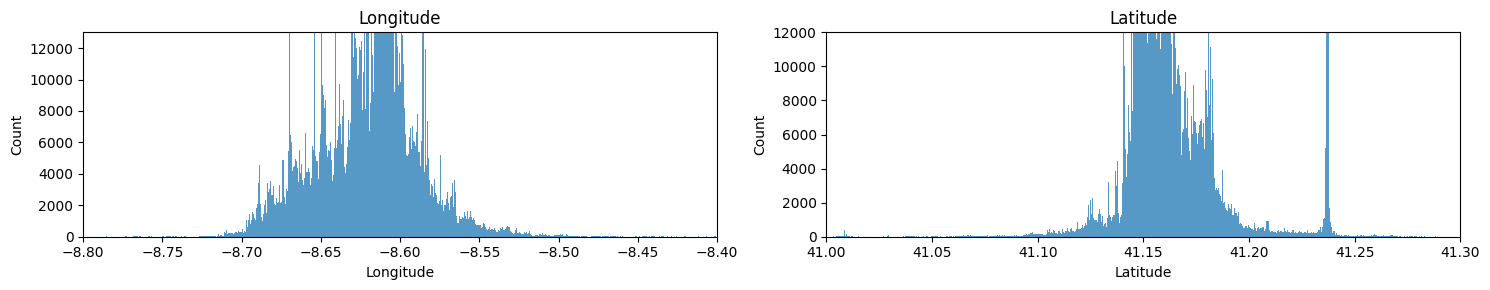

In [9]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

aux_lon = df4['lon_destino']
aux_lat = df4['lat_destino']

plt.subplot(1, 2, 1)
sns.histplot(data = aux_lon)
plt.xlabel('Longitude')
plt.xlim(-8.8, -8.4)
plt.ylim(0, 13000)
plt.title('Longitude')

plt.subplot(1, 2, 2) 
sns.histplot(data = aux_lat)
plt.xlabel('Latitude')
plt.xlim(41, 41.3)
plt.ylim(0, 12000)
plt.title('Latitude')

plt.tight_layout()
plt.show();

### 4.2 Análise bivariada

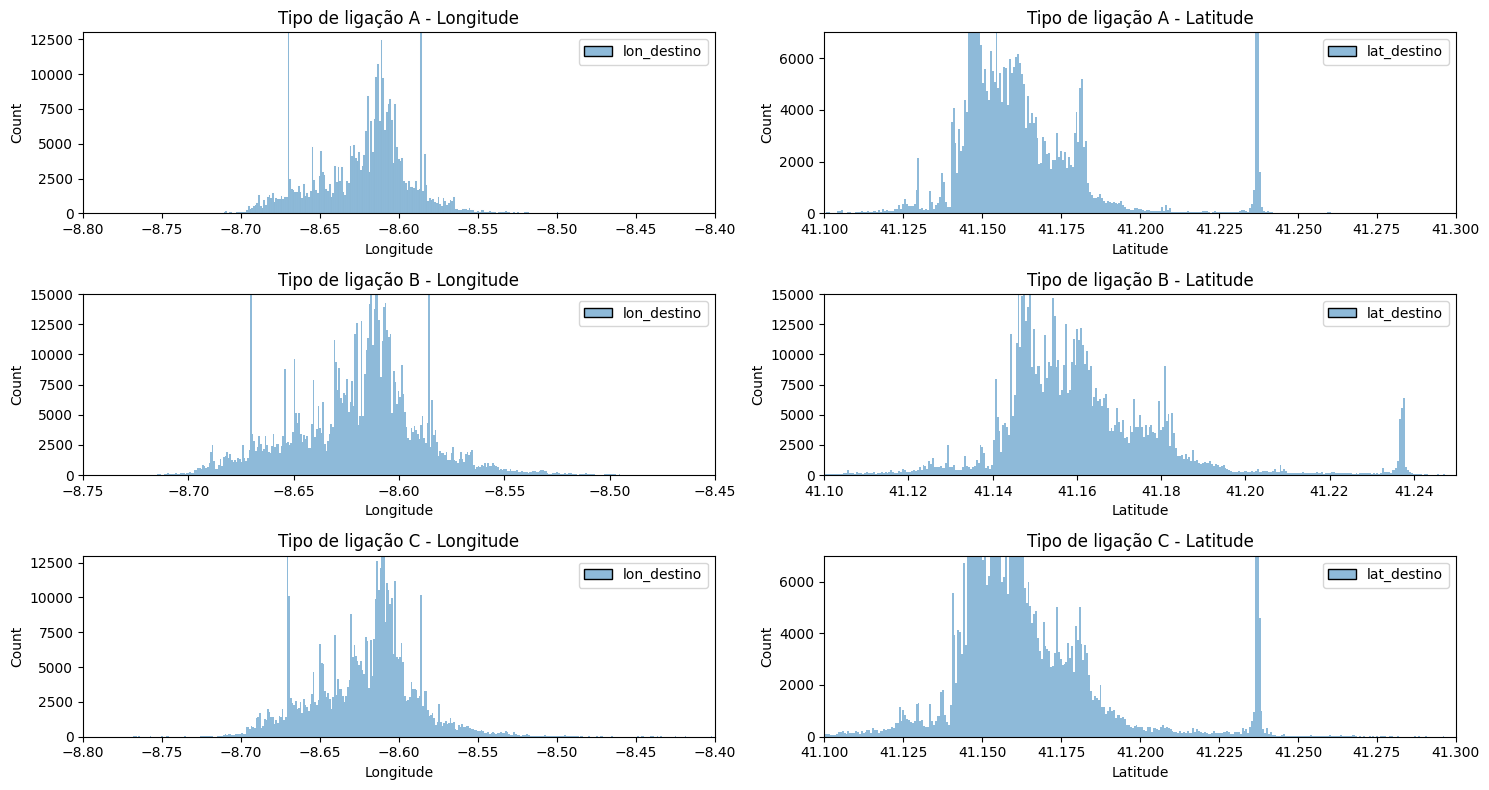

In [10]:
plt.figure(figsize = (15, 8)) #Ajuste o tamanho conforme necessário

aux_a_lon = df4.loc[df4['call_type'] == 'A', ['lon_destino']]
aux_a_lat = df4.loc[df4['call_type'] == 'A', ['lat_destino']]

plt.subplot(3, 2, 1)
sns.histplot(data = aux_a_lon)
plt.xlabel('Longitude')
plt.xlim(-8.8, -8.4)
plt.ylim(0, 13000)
plt.title('Tipo de ligação A - Longitude')

plt.subplot(3, 2, 2) 
sns.histplot(data = aux_a_lat)
plt.xlabel('Latitude')
plt.xlim(41.1, 41.3)
plt.ylim(0, 7000)
plt.title('Tipo de ligação A - Latitude')

aux_b_lon = df4.loc[df4['call_type'] == 'B', ['lon_destino']]
aux_b_lat = df4.loc[df4['call_type'] == 'B', ['lat_destino']]

plt.subplot(3, 2, 3)
sns.histplot(data = aux_b_lon)
plt.xlabel('Longitude')
plt.xlim(-8.75, -8.45)
plt.ylim(0, 15000);
plt.title('Tipo de ligação B - Longitude')

plt.subplot(3, 2, 4) 
sns.histplot(data = aux_b_lat)
plt.xlabel('Latitude')
plt.xlim(41.1, 41.25)
plt.ylim(0, 15000);
plt.title('Tipo de ligação B - Latitude')

aux_c_lon = df4.loc[df4['call_type'] == 'C', ['lon_destino']]
aux_c_lat = df4.loc[df4['call_type'] == 'C', ['lat_destino']]

plt.subplot(3, 2, 5)
sns.histplot(data = aux_c_lon)
plt.xlabel('Longitude')
plt.xlim(-8.8, -8.4)
plt.ylim(0, 13000);
plt.title('Tipo de ligação C - Longitude')

plt.subplot(3, 2, 6) 
sns.histplot(data = aux_c_lat)
plt.xlabel('Latitude')
plt.xlim(41.1, 41.3)
plt.ylim(0, 7000);
plt.title('Tipo de ligação C - Latitude')

plt.tight_layout()
plt.show();

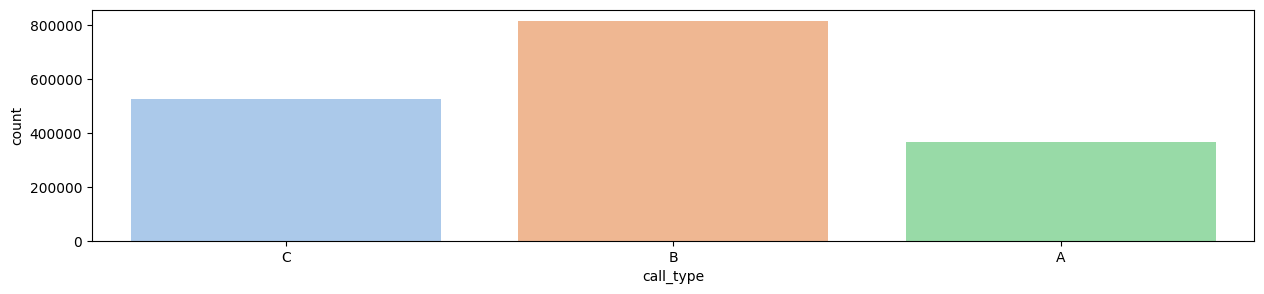

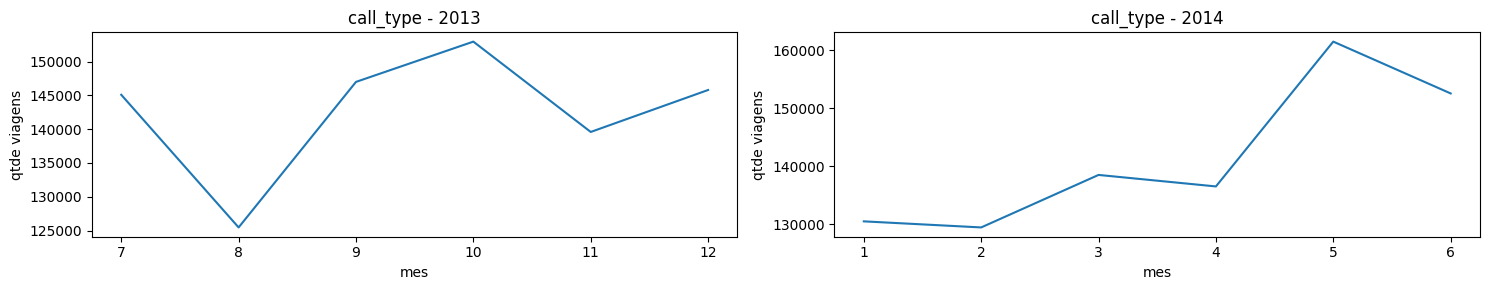

In [11]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

grid = GridSpec(1, 1) #Concatena os gráficos, neste caso precisarei de 2 linhas e 2 colunas

#call_type
plt.subplot(grid[0, 0])
sns.countplot(x = 'call_type', data = df4, palette = 'pastel')

fig, ax = plt.subplots(1, 2, figsize = (15, 3))
aux = df4.loc[df4['ano'] == 2013, ['mes', 'trip_id']].groupby('mes').count().sort_values('mes', ascending = False).reset_index()
sns.lineplot(x = 'mes', y = 'trip_id', data = aux, ax = ax[0])
ax[0].set_title('call_type - 2013')
ax[0].set_xlabel('mes')
ax[0].set_ylabel('qtde viagens')

aux1 = df4.loc[df4['ano'] == 2014, ['mes', 'trip_id']].groupby('mes').count().sort_values('mes', ascending = False).reset_index()
sns.lineplot(x = 'mes', y = 'trip_id', data = aux1, ax = ax[1])
ax[1].set_title('call_type - 2014')
ax[1].set_xlabel('mes')
ax[1].set_ylabel('qtde viagens')

plt.tight_layout();

In [12]:
df4[['call_type', 'origin_stand', 'taxi_id']].apply(lambda x: x.unique().shape[0])

call_type         3
origin_stand     64
taxi_id         444
dtype: int64

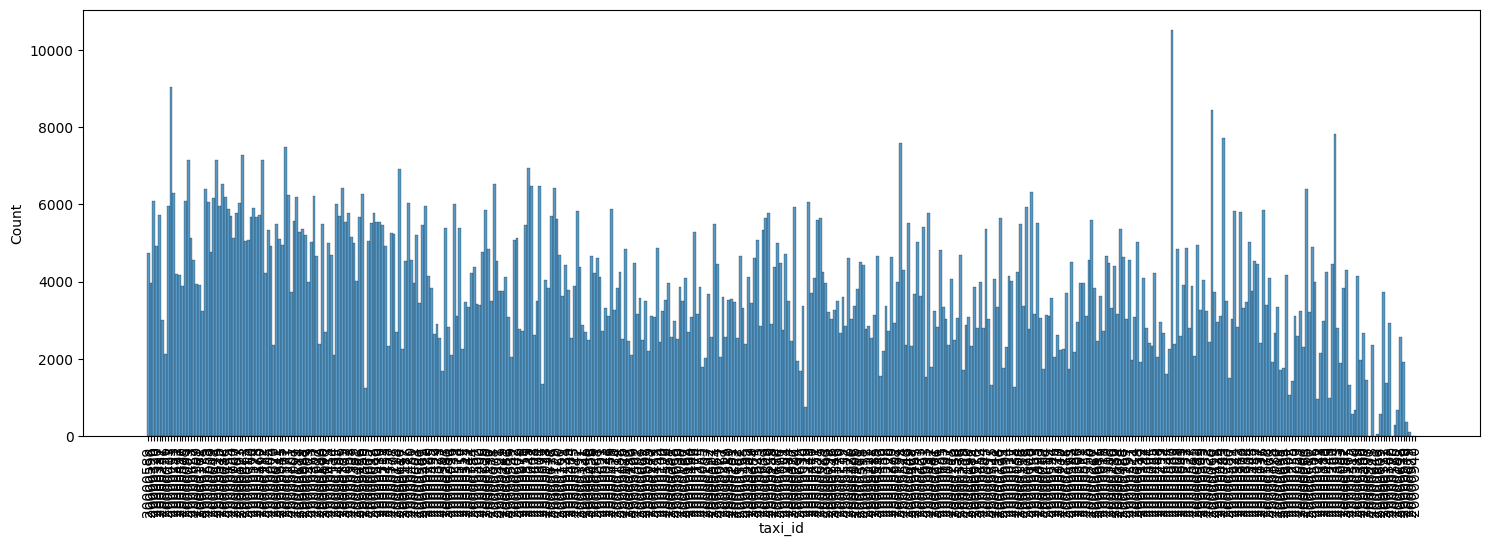

In [13]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

sns.histplot(data = df4['taxi_id'])
plt.tight_layout()
plt.xticks(rotation = 90);

#### 4.3.1 Variável numérica

In [14]:
#Encodando a variável 'call_type'
#One Hot Encoding
df4 = pd.get_dummies(df4, prefix = 'call_type', columns = ['call_type'])

df4_teste = pd.get_dummies(df4_teste, prefix = 'call_type', columns = ['call_type'])

In [15]:
#Adicionando a diferenças entre as coordenadas
df4['lat_delta'] = df4['lat_destino'] - df4['lat_partida']
df4['lon_delta'] = df4['lon_destino'] - df4['lon_partida']

df4_teste['lat_delta'] = df4_teste['lat_destino'] - df4_teste['lat_partida']
df4_teste['lon_delta'] = df4_teste['lon_destino'] - df4_teste['lon_partida']

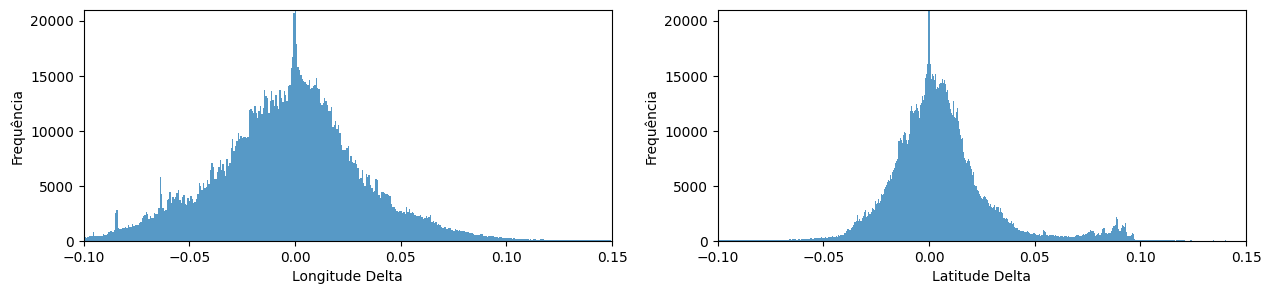

In [16]:
plt.figure(figsize = (15, 3)) #Ajuste o tamanho conforme necessário

grid = GridSpec(1, 2) #Concatena os gráficos, neste caso precisarei de 1 linha e 2 colunas

plt.subplot(grid[0, 0])
sns.histplot(df4['lon_delta'])
plt.xlabel('Longitude Delta')
plt.ylabel('Frequência')
plt.xlim(-0.1, 0.15)
plt.ylim(0, 21000)

plt.subplot(grid[0, 1])
sns.histplot(df4['lat_delta'])
plt.xlabel('Latitude Delta')
plt.ylabel('Frequência')
plt.xlim(-0.1, 0.15)
plt.ylim(0, 21000);
plt.show();

In [17]:
numericos = df4.select_dtypes(exclude = ['object'])
categoricos = df4.select_dtypes(include = ['object'])

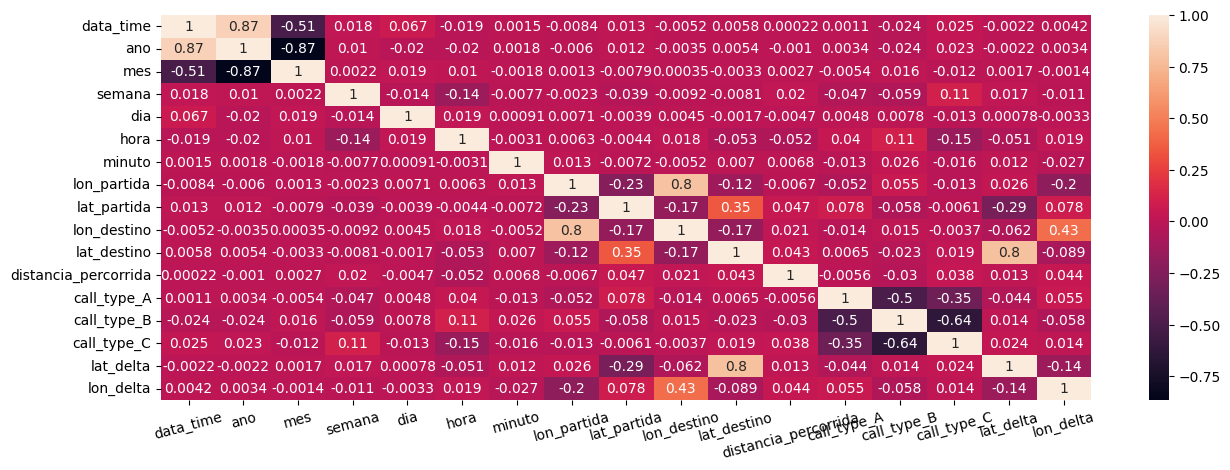

In [18]:
plt.figure(figsize = (15, 5)) #Ajuste o tamanho conforme necessário

correlation = numericos.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)
plt.xticks(rotation = 15);

# 5. (Modelagem dos dados) Passo 5: Preparação dos dados

In [2]:
import pickle
#pickle.dump(df4, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df4.pkl', 'wb'))
#pickle.dump(df4_teste, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df4_teste.pkl', 'wb'))

df4 = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df4.pkl', 'rb'))
df4_teste = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df4_teste.pkl', 'rb'))

df5 = df4.copy()
df5_teste = df4_teste.copy()

In [3]:
a = df5.select_dtypes(include = ['int32', 'float64'])
a.head(3)

,ano,mes,semana,dia,hora,minuto,lon_partida,lat_partida,lon_destino,lat_destino,distancia_percorrida,lat_delta,lon_delta
0,2013,7,0,1,0,0,-8.618643,41.141412,-8.630838,41.154489,1776.81,0.013077,-0.012195
1,2013,7,0,1,0,8,-8.639847,41.159826,-8.665740,41.170671,2480.36,0.010845,-0.025893
2,2013,7,0,1,0,2,-8.612964,41.140359,-8.615970,41.140530,252.44,0.000171,-0.003006


### 5.1 Dados de treino

#### 5.1.1 Variável numérica

##### <s>5.1.1.1 Padronização</s>

##### 5.1.1.2 Normalização

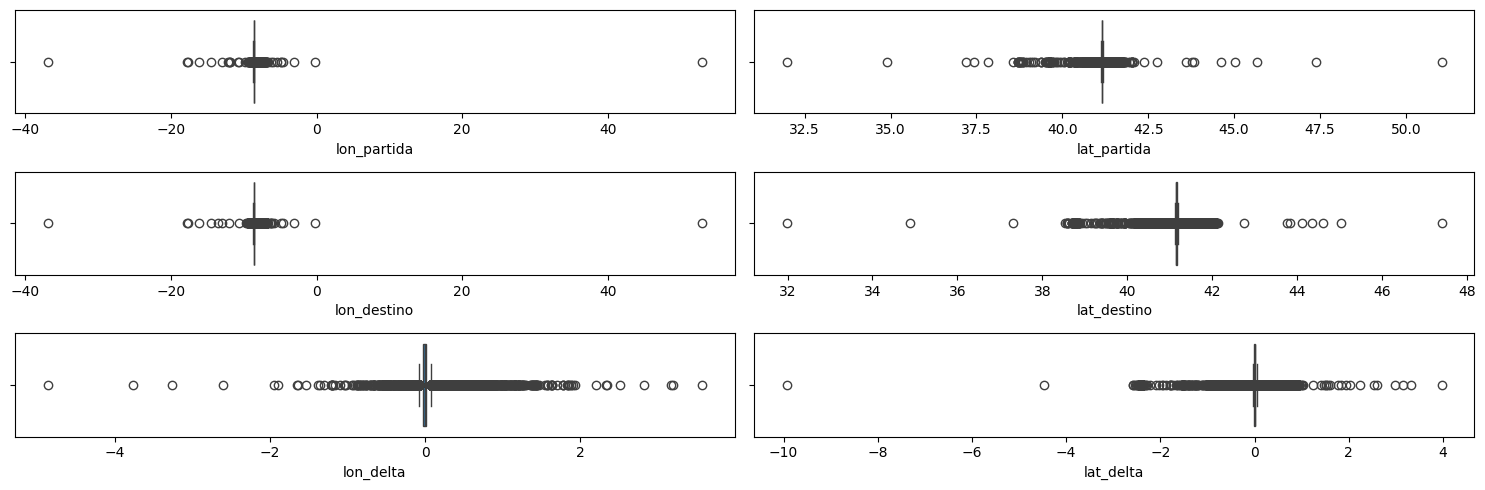

In [8]:
plt.figure(figsize = (15,5))

#'lon_partida'
plt.subplot(3, 2, 1)
sns.boxplot(df5['lon_partida'], orient = 'h')

#'lat_partida'
plt.subplot(3, 2, 2)
sns.boxplot(df5['lat_partida'], orient = 'h')

#'lon_destino'
plt.subplot(3, 2, 3)
sns.boxplot(df5['lon_destino'], orient = 'h')

#'lat_destino'
plt.subplot(3, 2, 4)
sns.boxplot(df5['lat_destino'], orient = 'h')

#'lon_delta'
plt.subplot(3, 2, 5)
sns.boxplot(df5['lon_delta'], orient = 'h')

#'lat_delta'
plt.subplot(3, 2, 6)
sns.boxplot(df5['lat_delta'], orient = 'h')
plt.tight_layout();

In [9]:
rs = RobustScaler()
mms = MinMaxScaler()

#'lon_partida'
df5['lon_partida'] = rs.fit_transform(df5[['lon_partida']].values)

#'lat_partida'
df5['lat_partida'] = rs.fit_transform(df5[['lat_partida']].values)

#'lon_delta'
df5['lon_delta'] = rs.fit_transform(df5[['lon_delta']].values)

#'lat_delta'
df5['lat_delta'] = rs.fit_transform(df5[['lat_delta']].values)

#'distancia_percorrida'
df5['distancia_percorrida'] = rs.fit_transform(df5[['distancia_percorrida']].values)

#'ano'
df5['ano'] = mms.fit_transform(df5[['ano']].values)

#### 5.1.2 Variável categórica

##### 5.1.2.1 Encoding

In [10]:
b = df5.select_dtypes(exclude = ['int32', 'float64'])
b.head(3)

,trip_id,origin_call,origin_stand,taxi_id,data_time,data_hora,call_type_A,call_type_B,call_type_C
0,1372636858620000589,0.0,0.0,20000589,2013-07-01 00:00:58+00:00,2013-07-01 00:00:58,False,False,True
1,1372637303620000596,0.0,7.0,20000596,2013-07-01 00:08:23+00:00,2013-07-01 00:08:23,False,True,False
2,1372636951620000320,0.0,0.0,20000320,2013-07-01 00:02:31+00:00,2013-07-01 00:02:31,False,False,True


In [11]:
le = LabelEncoder()

#'origin_call' -> Label Enconding
df5['origin_call'] = le.fit_transform(df5['origin_call'])

#'origin_stand' -> Label Enconding
df5['origin_stand'] = le.fit_transform(df5['origin_stand'])

#'taxi_id'
df5['taxi_id'] = le.fit_transform(df5['taxi_id'])

#### 5.2 Transformação de natureza

In [12]:
#mes
periodo_ciclico = 12
df5['mes_sen'] = df5['mes'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['mes_cos'] = df5['mes'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#semana
periodo_ciclico = 7
df5['semana_sen'] = df5['semana'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['semana_cos'] = df5['semana'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#dia
periodo_ciclico = 30
df5['dia_sen'] = df5['dia'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['dia_cos'] = df5['dia'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#hora
periodo_ciclico = 24
df5['hora_sen'] = df5['hora'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['hora_cos'] = df5['hora'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#minuto
periodo_ciclico = 60
df5['minuto_sen'] = df5['minuto'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5['minuto_cos'] = df5['minuto'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

### 5.3 Dados de teste

#### 5.3.1 Variável numérica

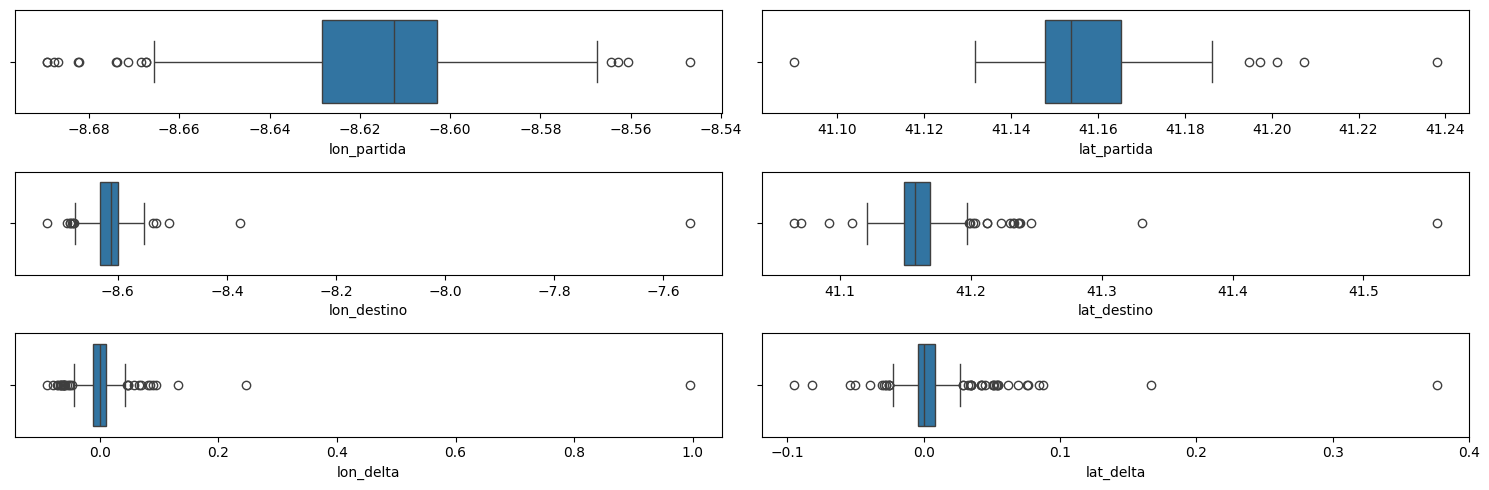

In [13]:
plt.figure(figsize = (15,5))

#'lon_partida'
plt.subplot(3, 2, 1)
sns.boxplot(df5_teste['lon_partida'], orient = 'h')

#'lat_partida'
plt.subplot(3, 2, 2)
sns.boxplot(df5_teste['lat_partida'], orient = 'h')

#'lon_destino'
plt.subplot(3, 2, 3)
sns.boxplot(df5_teste['lon_destino'], orient = 'h')

#'lat_destino'
plt.subplot(3, 2, 4)
sns.boxplot(df5_teste['lat_destino'], orient = 'h')

#'lon_delta'
plt.subplot(3, 2, 5)
sns.boxplot(df5_teste['lon_delta'], orient = 'h');

#'lat_delta'
plt.subplot(3, 2, 6)
sns.boxplot(df5_teste['lat_delta'], orient = 'h')
plt.tight_layout();

In [14]:
pd.set_option('display.max_columns', None)
df5.head()

,trip_id,origin_call,origin_stand,taxi_id,data_time,ano,mes,semana,dia,hora,minuto,data_hora,lon_partida,lat_partida,lon_destino,lat_destino,distancia_percorrida,call_type_A,call_type_B,call_type_C,lat_delta,lon_delta,mes_sen,mes_cos,semana_sen,semana_cos,dia_sen,dia_cos,hora_sen,hora_cos,minuto_sen,minuto_cos
0,1372636858620000589,0,0,366,2013-07-01 00:00:58+00:00,0.0,7,0,1,0,0,2013-07-01 00:00:58,-0.233618,-0.843494,-8.630838,41.154489,-0.294538,False,False,True,0.491264,-0.289570,-0.5,-0.866025,0.0,1.0,0.207912,0.978148,0.0,1.0,0.000000,1.000000
1,1372637303620000596,0,61,370,2013-07-01 00:08:23+00:00,0.0,7,0,1,0,8,2013-07-01 00:08:23,-1.072650,0.355803,-8.665740,41.170671,-0.030028,False,True,False,0.390492,-0.637694,-0.5,-0.866025,0.0,1.0,0.207912,0.978148,0.0,1.0,0.743145,0.669131
2,1372636951620000320,0,0,203,2013-07-01 00:02:31+00:00,0.0,7,0,1,0,2,2013-07-01 00:02:31,-0.008903,-0.912075,-8.615970,41.140530,-0.867646,False,False,True,-0.091426,-0.056038,-0.5,-0.866025,0.0,1.0,0.207912,0.978148,0.0,1.0,0.207912,0.978148
3,1372636854620000520,0,0,329,2013-07-01 00:00:54+00:00,0.0,7,0,1,0,0,2013-07-01 00:00:54,1.506054,-0.157093,-8.607996,41.142915,0.152254,False,False,True,-0.507111,-0.826395,-0.5,-0.866025,0.0,1.0,0.207912,0.978148,0.0,1.0,0.000000,1.000000
4,1372637091620000337,0,0,216,2013-07-01 00:04:51+00:00,0.0,7,0,1,0,4,2013-07-01 00:04:51,-1.315883,1.701641,-8.687268,41.178087,0.340007,False,False,True,-0.207639,-1.028591,-0.5,-0.866025,0.0,1.0,0.207912,0.978148,0.0,1.0,0.406737,0.913545


In [15]:
rs = RobustScaler()
mms = MinMaxScaler()

#'lon_partida'
df5_teste['lon_partida'] = rs.fit_transform(df5_teste[['lon_partida']].values)

#'lat_partida'
df5_teste['lat_partida'] = rs.fit_transform(df5_teste[['lat_partida']].values)

#'lon_delta'
df5_teste['lon_delta'] = rs.fit_transform(df5_teste[['lon_delta']].values)

#'lat_delta'
df5_teste['lat_delta'] = rs.fit_transform(df5_teste[['lat_delta']].values)

#'distancia_percorrida'
df5_teste['distancia_percorrida'] = rs.fit_transform(df5_teste[['distancia_percorrida']].values)

#'ano'
df5_teste['ano'] = mms.fit_transform(df5_teste[['ano']].values)

#### 5.3.2 Variável categórica

In [16]:
le = LabelEncoder()

#'origin_call' -> Label Enconding
df5_teste['origin_call'] = le.fit_transform(df5_teste['origin_call'])

#'origin_stand' -> Label Enconding
df5_teste['origin_stand'] = le.fit_transform(df5_teste['origin_stand'])

#### 5.4 Transformação de natureza

In [17]:
#mes
periodo_ciclico = 12
df5_teste['mes_sen'] = df5_teste['mes'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5_teste['mes_cos'] = df5_teste['mes'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#semana
periodo_ciclico = 7
df5_teste['semana_sen'] = df5_teste['semana'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5_teste['semana_cos'] = df5_teste['semana'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#dia
periodo_ciclico = 30
df5_teste['dia_sen'] = df5_teste['dia'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5_teste['dia_cos'] = df5_teste['dia'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#hora
periodo_ciclico = 24
df5_teste['hora_sen'] = df5_teste['hora'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5_teste['hora_cos'] = df5_teste['hora'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

#minuto
periodo_ciclico = 60
df5_teste['minuto_sen'] = df5_teste['minuto'].apply(lambda x: np.sin(x * (2 * np.pi / periodo_ciclico)))
df5_teste['minuto_cos'] = df5_teste['minuto'].apply(lambda x: np.cos(x * (2 * np.pi / periodo_ciclico)))

# 6. (Modelagem dos dados) Passo 6: Seleção das variáveis

In [14]:
import pickle
#pickle.dump(df5, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df5.pkl', 'wb'))
#pickle.dump(df5_teste, open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df5_teste.pkl', 'wb'))

df5 = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df5.pkl', 'rb'))
df5_teste = pickle.load(open('/home/leonardo/projetos_/trajetoria_taxi/dataset/df5_teste.pkl', 'rb'))

df6 = df5.copy()
df6_teste = df5_teste.copy()

### 6.1 Selecionar as variáveis mais relevantes

In [15]:
#Classificando os dados pela data mais antiga para a mais nova para passar no cross validation
df6 = df6.sort_values('data_hora', ascending = True)
df6_teste = df6_teste.sort_values('data_hora', ascending = True)

In [16]:
#Deletar as variáveis originais que tiveram as colunas que foram criadas
#a partir delas, pois quanto mais colunas mais complexo fica o modelo
cols_drop = ['trip_id', 'taxi_id', 'data_time', 'ano', 'mes', 'semana', 'dia', 'hora', 'minuto', 'data_hora']

df6 = df6.drop(cols_drop, axis = 1)
df6_teste = df6_teste.drop(cols_drop, axis = 1)

In [17]:
#Separando as variáveis resposta
x = df6.drop(['lon_destino', 'lat_destino'], axis = 1)
x_teste = df6_teste.drop(['lon_destino', 'lat_destino'], axis = 1)

y = df6[['lon_destino', 'lat_destino']].copy()
y_teste = df6_teste[['lon_destino', 'lat_destino']].copy()

#### 6.1.1 Implementar o Boruta

In [18]:
#Retirando as colunas 'data_time'
#x_treino_drop = x.drop(['data_time'], axis = 1).values

# Agrupando as variáveis de resposta
#y_treino_drop = {'lon': y_lon.values, 'lat': y_lat.values}

#Instanciando o algoritmo de Random Forest
#rf = RandomForestRegressor(n_jobs = -1)

#Boruta espera receber um vetor e não dataframe
# Iniciando o modelo para longitude e latitude
#boruta = {'lon': BorutaPy(rf, n_estimators = 2, verbose = 2, random_state = 42).fit(x_treino_drop, y_treino_drop['lon']),
#          'lat': BorutaPy(rf, n_estimators = 2, verbose = 2, random_state = 42).fit(x_treino_drop, y_treino_drop['lat'])}

In [19]:
#x_treino_aux = x.drop(['data_time'], axis = 1)

#cols_selecionadas_boruta_lon = {i: col for i, col in enumerate(x_treino_aux.columns[boruta['lon'].support_].tolist())}
#cols_selecionadas_boruta_lat = {i: col for i, col in enumerate(x_treino_aux.columns[boruta['lat'].support_].tolist())}

#print('Colunas selecionadas longitude: {}'.format(cols_selecionadas_boruta_lon))
#print('Colunas selecionadas latitude: {}'.format(cols_selecionadas_boruta_lat))

In [20]:
#Colunas relevantes segundo Boruta
colunas_selecionadas_boruta = ['lon_partida', 
                               'lon_delta',
                               'lat_partida', 
                               'lat_delta']
 
colunas_nao_selecionadas_boruta = ['origin_call',
                                   'origin_stand',
                                   'distancia_percorrida',
                                   'call_type_A',
                                   'call_type_B',
                                   'call_type_C',
                                   'mes_sen',
                                   'mes_cos',
                                   'semana_sen',
                                   'semana_cos',
                                   'dia_sen',
                                   'dia_cos',
                                   'hora_sen',
                                   'hora_cos',
                                   'minuto_sen',
                                   'minuto_cos']

colunas_adicionadas = ['origin_call', 
                       'origin_stand',
                       'distancia_percorrida',
                       'call_type_A',
                       'call_type_B',
                       'call_type_C',
                       'mes_sen',
                       'mes_cos',
                       'semana_sen',
                       'semana_cos',
                       'dia_sen',
                       'dia_cos',
                       'hora_sen',
                       'hora_cos',
                       'minuto_sen',
                       'minuto_cos'] #Foram adicionadas após verificar que as métricas estavam ruins

colunas_selecionadas = colunas_selecionadas_boruta + colunas_adicionadas

In [21]:
x_treino = x.loc[:, colunas_selecionadas]
y_treino = y

x_teste = x_teste.loc[:, colunas_selecionadas]
y_teste = y_teste

# 7. (Algoritmos de ML) Passo 7: Implementar os modelos de machine learning

### <s>7.1 Separar os dados em treino e validação</s>

In [22]:
  #Foi feita uma função para a separação

### 7.2 Algoritmo Regressão linear

In [23]:
lr = LinearRegression()

resultado_lr = cross_validation('Regressão linear', lr, x_treino, False)
resultado_lr

,algoritmo,rmse,mae,mape
0,Regressão linear,0.0+/-0.0,0.0+/-0.0,0.0+/-0.0


### 7.3 Algoritmo Random forest

In [24]:
rf = RandomForestRegressor(n_estimators = 10, max_depth = 2, n_jobs = -1, random_state = 42)

resultado_rf = cross_validation('Random forest', rf, x_treino, False)

resultado_rf

,algoritmo,rmse,mae,mape
0,Random forest,0.0445+/-0.0219,0.0155+/-0.0002,0.0012+/-0.0


### 7.4 Algoritmo XGboost

In [25]:
xgb_ = XGBRegressor(n_estimators = 10, max_depth = 2, n_jobs = -1, random_state = 42)

resultado_xgb = cross_validation('XGboost', xgb_, x_treino, False)

resultado_xgb

,algoritmo,rmse,mae,mape
0,XGboost,0.0406+/-0.0237,0.0077+/-0.0003,0.0006+/-0.0


### 7.5 Performance dos modelos

In [26]:
#pd.set_option('display.float_format', lambda x: '%.12f' % x)

In [33]:
resultado = pd.concat([resultado_lr, resultado_rf, resultado_xgb]).reset_index(drop = True)
#resultado.style.set_caption('Dados de validação')
resultado.style.highlight_min(subset = ['rmse'], color = 'red')

,algoritmo,rmse,mae,mape
0,Regressão linear,0.0+/-0.0,0.0+/-0.0,0.0+/-0.0
1,Random forest,0.0445+/-0.0219,0.0155+/-0.0002,0.0012+/-0.0
2,XGboost,0.0406+/-0.0237,0.0077+/-0.0003,0.0006+/-0.0


# 8. (Algoritmos de Ml) Passo 8: Ajuste dos hiperparâmetros no algoritmo

### 8.2 Treinar modelo escolhido com os melhores parâmetros

In [28]:
#Fazendo a predição com os dados de teste
lr = LinearRegression()

multioutput_regressor = MultiOutputRegressor(lr)

multioutput_regressor.fit(x_treino, y_treino)

y_pred_lr = multioutput_regressor.predict(x_teste)

resultado_lr_ = metricas_error('Regressão linear', y_teste, y_pred_lr)
resultado_lr_

,nome_algoritmo,mae,mape,rmse
0,Regressão linear,0.013676,0.001079,0.037653


In [29]:
#Fazendo a predição com os dados de teste
rf = RandomForestRegressor(n_estimators = 50, max_depth = 2, n_jobs = -1, random_state = 42)

multioutput_regressor = MultiOutputRegressor(rf)

multioutput_regressor.fit(x_treino, y_treino)

y_pred_rf = multioutput_regressor.predict(x_teste)

resultado_rf_ = metricas_error('Random forest', y_teste, y_pred_rf)
resultado_rf_

,nome_algoritmo,mae,mape,rmse
0,Random forest,0.017672,0.001489,0.045261


In [30]:
#Fazendo a predição com os dados de teste
xgb_ = XGBRegressor(n_estimators = 50, max_depth = 2, n_jobs = -1, random_state = 42)

multioutput_regressor = MultiOutputRegressor(xgb_)

multioutput_regressor.fit(x_treino, y_treino)

y_pred_xgb_ = multioutput_regressor.predict(x_teste)

resultado_xgb_ = metricas_error('XGboost', y_teste, y_pred_xgb_)
resultado_xgb_

,nome_algoritmo,mae,mape,rmse
0,XGboost,0.013641,0.001041,0.034343


In [32]:
resultado = pd.concat([resultado_lr_, resultado_rf_, resultado_xgb_]).reset_index(drop = True)
#resultado.style.set_caption('Dados de teste')
resultado.style.highlight_min(subset = ['rmse'], color = 'red')

,nome_algoritmo,mae,mape,rmse
0,Regressão linear,0.013676,0.001079,0.037653
1,Random forest,0.017672,0.001489,0.045261
2,XGboost,0.013641,0.001041,0.034343


# 9. (Avaliação do algoritmo) Passo 9: Performance do negócio

In [86]:
resultado = pd.DataFrame(y_pred_xgb_, columns = ['Predicao_lon', 'Predicao_lat'])
resultado.style.set_caption('Com as predicoes')

,Predicao_lon,Predicao_lat
0,-8.345249,41.434837
1,-8.646899,41.142006
2,-8.670191,41.265549
3,-8.623500,41.163036
4,-8.534871,41.148140
5,-8.623417,41.162376
6,-8.797140,41.413635
7,-8.647690,41.167465
8,-8.676576,41.272598
9,-8.589801,41.239658


In [36]:
aux = df1_localizacao.copy()

In [ ]:
dist_final = []
for a in range(1, aux.shape[0]):
    if a not in aux.index:
        continue  # Ignora a iteração se o índice não existir em aux
    
    for b in range(1, df5.shape[0]):
        if b not in df5.index:
            continue  # Ignora a iteração se o índice não existir em df5
        lat1, lon1 = map(float, [aux.loc[a, 'Latitude'], aux.loc[a, 'Longitude']])
        lat2, lon2 = map(float, [df5.loc[b, 'lat_destino'], df5.loc[b, 'lon_destino']])
        
        # Convertendo graus para radianos
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        dist = haversine(lat1, lon1, lat2, lon2)
        
        if not dist_final or dist < min(dist_final):
            dist_final.append(dist)